Importing Libraries.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
import time
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler,LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GRU, Dense, Dropout, Flatten, TimeDistributed
import os
from tensorflow.keras.utils import to_categorical

In [2]:
print("GPU Devices:", tf.config.list_physical_devices('GPU'))

GPU Devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


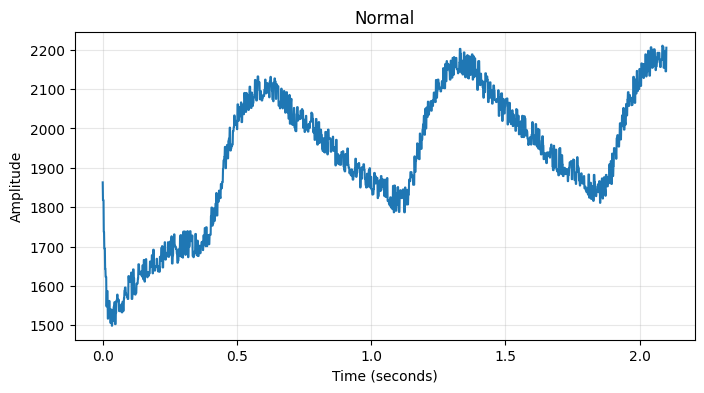

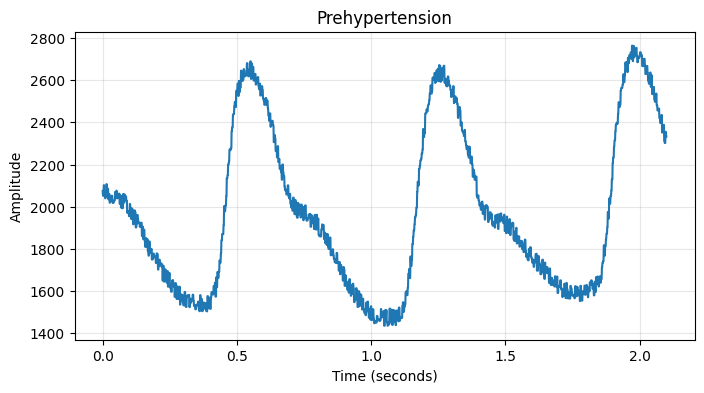

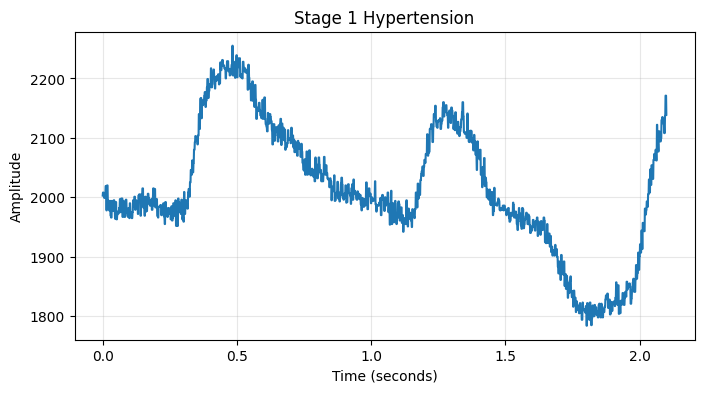

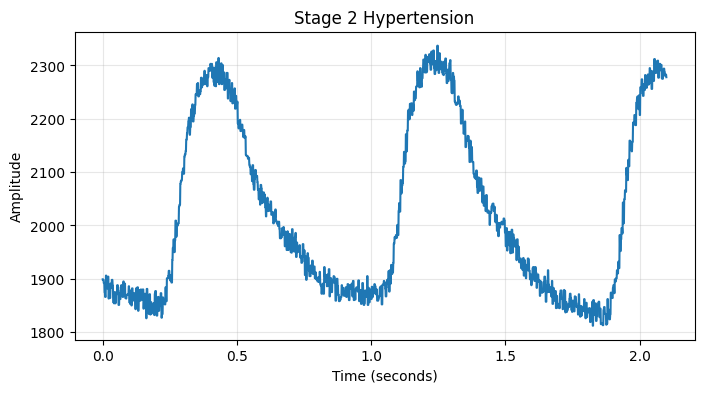

In [3]:
def load_dataset(location_folder,location_excel_file):
  Hyp_str_int ={"Normal":0,"Prehypertension":1,"Stage 1 hypertension":2,"Stage 2 hypertension":3}
  excel_load=pd.read_excel(location_excel_file,header=1)
  ppg_signal=[]
  CVD_label=[]
  demographics=[]
  for fname in os.listdir(location_folder):
    file_path=os.path.join(location_folder,fname)
    signal=np.loadtxt(file_path)
    if(signal.shape[0]!=2100):
      continue
    subject_id=int(fname.split("_")[0])
    row=excel_load[excel_load["subject_ID"]==subject_id]
    CVD_str=row["Hypertension"].values[0]
    CVD_labels=Hyp_str_int.get(CVD_str,None)
    ppg_signal.append(signal)
    CVD_label.append(CVD_labels)
    demographics.append(row.iloc[0].to_dict())
  ppg_signal=np.array(ppg_signal)
  CVD_label=np.array(CVD_label)
  demographics=pd.DataFrame(demographics)
  return {"ppg":ppg_signal,"cvd":CVD_label,"demo":demographics}

def visualize_one_signal_from_each_class(signals, labels, no_of_classes):
    class_name = ["Normal", "Prehypertension", "Stage 1 Hypertension", "Stage 2 Hypertension"]
    t = np.linspace(0, 2.1, 2100)

    for class_idx in range(no_of_classes):
        idx = np.where(labels == class_idx)[0]
        if len(idx) == 0:
            print(f"No samples for class {class_name[class_idx]}")
            continue

        first_index_only = idx[0]
        plt.figure(figsize=(8,4))
        plt.plot(t, signals[first_index_only])
        plt.title(f'{class_name[class_idx]}')
        plt.xlabel("Time (seconds)")
        plt.ylabel("Amplitude")
        plt.grid(True, alpha=0.3)
        plt.show()


location_folder="/content/drive/MyDrive/0_subject"
location_excel_file="/content/drive/MyDrive/PPG-BP dataset.xlsx"
data = load_dataset(location_folder,location_excel_file)
signals=data["ppg"]
CVD_labels=data["cvd"]
visualize_one_signal_from_each_class(signals,CVD_labels,4)

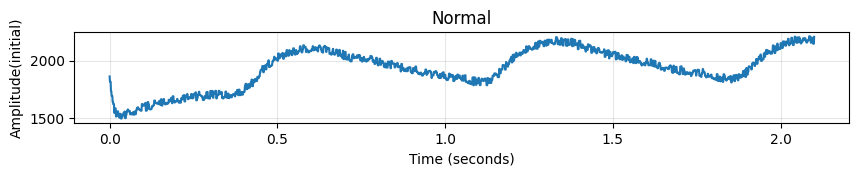

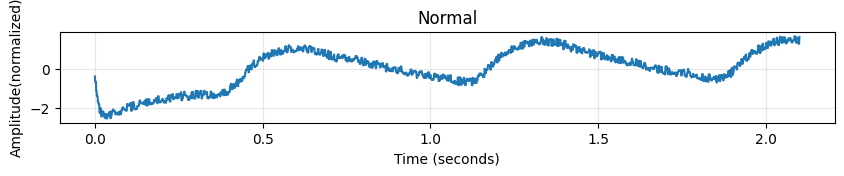

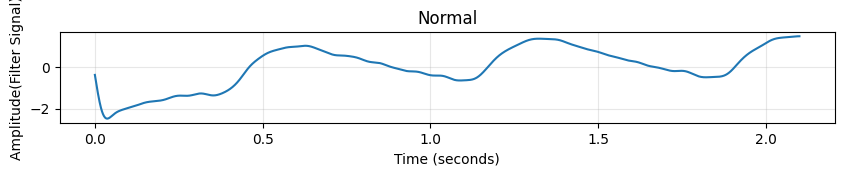

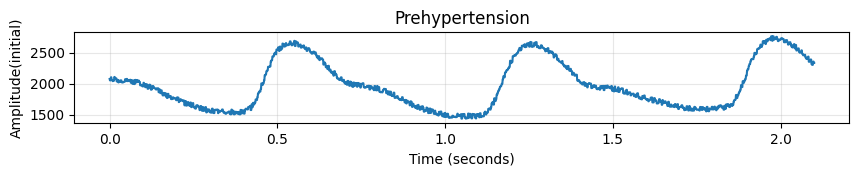

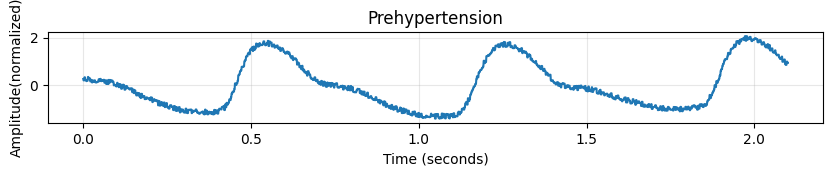

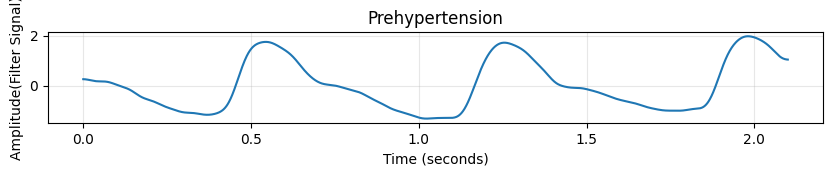

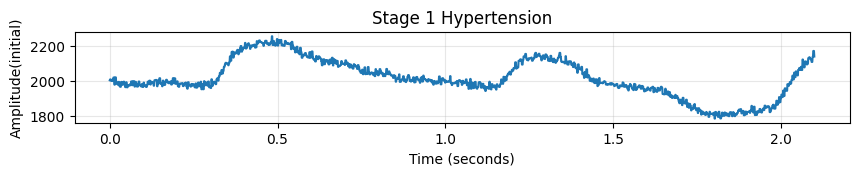

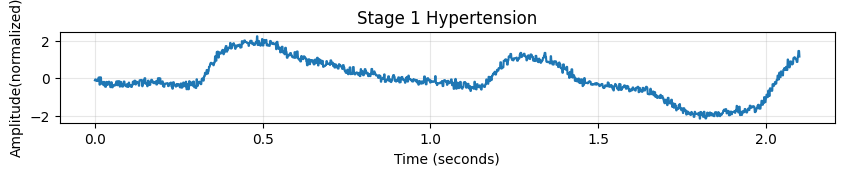

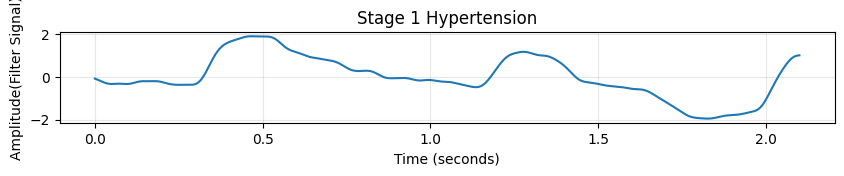

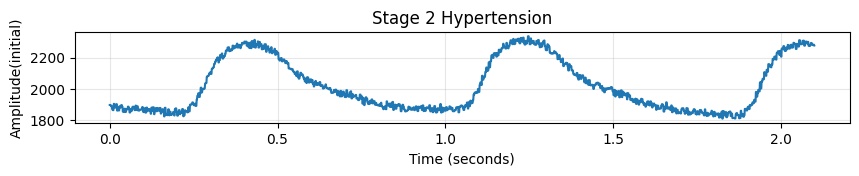

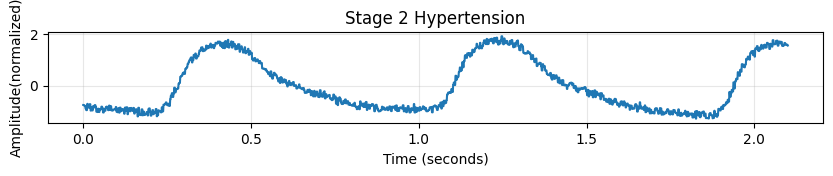

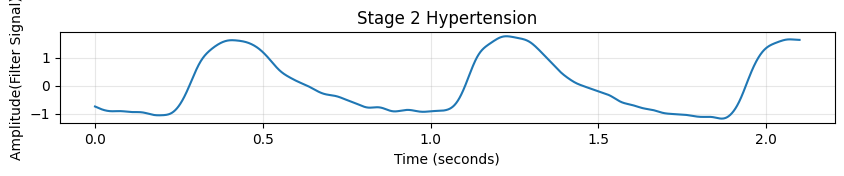

In [4]:
def Z_score_Normalization(signals):
  normalized=[]
  for sns in signals:
    m=np.mean(sns)
    std=np.std(sns)
    normal=(sns-m)/std
    normalized.append(normal)
  return normalized
normalized=Z_score_Normalization(signals)

def butterworth(signals,cutoff,order,sampling_frequency):
  wn=(2*cutoff)/(sampling_frequency)
  filter=[]
  b,a=butter(order,wn,btype='low',analog=False)
  for sns in signals:
    filter_signal=filtfilt(b,a,sns)
    filter.append(filter_signal)
  return filter
filtered_signal=butterworth(normalized,15,4,1000)

def visualize_one_signal_from_class_after_processing(signals, labels, no_of_classes,normalized,filtered_signal):
    class_name = ["Normal", "Prehypertension", "Stage 1 Hypertension", "Stage 2 Hypertension"]
    t = np.linspace(0, 2.1, 2100)

    for class_idx in range(no_of_classes):
        idx = np.where(labels == class_idx)[0]
        if len(idx) == 0:
            print(f"No samples for class {class_name[class_idx]}")
            continue

        first_index_only = idx[0]
        plt.figure(figsize=(10,4))
        plt.subplot(3,1,1)
        plt.plot(t, signals[first_index_only])
        plt.title(f'{class_name[class_idx]}')
        plt.xlabel("Time (seconds)")
        plt.ylabel("Amplitude(initial)")
        plt.grid(True, alpha=0.3)

        plt.figure(figsize=(10,4))
        plt.subplot(3,1,2)
        plt.plot(t, normalized[first_index_only])
        plt.title(f'{class_name[class_idx]}')
        plt.xlabel("Time (seconds)")
        plt.ylabel("Amplitude(normalized)")
        plt.grid(True, alpha=0.3)

        plt.figure(figsize=(10,4))
        plt.subplot(3,1,3)
        plt.plot(t, filtered_signal[first_index_only])
        plt.title(f'{class_name[class_idx]}')
        plt.xlabel("Time (seconds)")
        plt.ylabel("Amplitude(Filter Signal)")
        plt.grid(True, alpha=0.3)
        plt.show()

visualize_one_signal_from_class_after_processing(signals,CVD_labels,4,normalized,filtered_signal)
filt_sig=np.array(filtered_signal)
X = filt_sig.reshape((filt_sig.shape[0], filt_sig.shape[1], 1))
Y_int=np.array(CVD_labels)
Y = to_categorical(Y_int, num_classes=4)

In [12]:
def create_cnn_gru_model(input_shape=(2100,1),num_classes=4):
  model=Sequential([
      tf.keras.layers.Input(shape=input_shape),
      Conv1D(filters=32,kernel_size=3,activation='relu',name='conv1d_1'),
      MaxPooling1D(pool_size=2,name='maxpool_1'),

      Conv1D(filters=64,kernel_size=3,activation='relu',name='conv1d_2'),
      MaxPooling1D(pool_size=2,name='maxpool_2'),

      #Dropout(0.2),
      GRU(256,activation='relu'),

      Dropout(0.2),
      Dense(64,activation='relu',name='dense_1'),
      Dense(64,activation='relu',name='dense_2'),
      Dense(num_classes,activation='softmax',name='output')
  ])
  model.compile(
      optimizer=Adam(learning_rate=0.001),
      loss='categorical_crossentropy',
      metrics=['accuracy','precision','recall']
  )
  return model

TRAINING_CONFIG={
    'epochs':120,
    'batch_size':32,
    'optimizer':'Adam',
    'learning_rate':0.001,
    'loss':'categorical_crossentropy',
    'validation_split':0.1,
    'cv_folds':10
}

def evaluate_fold(model,X_test,Y_test,fold_num):
  y_predicted_probabilities=model.predict(X_test,verbose=0)
  y_pred=np.argmax(y_predicted_probabilities,axis=1)
  y_true=np.argmax(Y_test,axis=1)

  accuracy=accuracy_score(y_true,y_pred)
  precision=precision_score(y_true,y_pred,average='macro',zero_division=0)
  recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
  f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

  metrics = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1_score': f1,}

  return metrics

In [8]:

def train_single_fold(X_train,Y_train,X_val,Y_val,epochs=120,batch_size=32):
  model=create_cnn_gru_model()
  callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=15,
            restore_best_weights=True,
            verbose=0)]
  start_time=time.time()
  history = model.fit(
        X_train, Y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(X_val, Y_val),
        callbacks=callbacks,
        verbose=0
    )
  training_time=time.time()-start_time
  return model,history

def train_for_k_folds(n_folds,X,Y):
  y_classes = np.argmax(Y, axis=1)
  skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
  fold_info=[]
  allmodels=[]
  for fold ,(train_idx,test_idx) in enumerate(skf.split(X,y_classes),1):
    X_train=X[train_idx]
    X_test=X[test_idx]
    Y_train=Y[train_idx]
    Y_test=Y[test_idx]
    validation_length=int(len(train_idx)*0.2)
    X_val=X_train[:validation_length]
    Y_val=Y_train[:validation_length]
    X_train=X_train[validation_length:]
    Y_train=Y_train[validation_length:]
    model,history=train_single_fold(X_train,Y_train,X_val,Y_val,120,32)
    metrics=evaluate_fold(model,X_test,Y_test,fold)
    fold_info.append({'metrics':metrics,'fold_num':fold})
    print(f"Fold {fold}: {metrics}")
    allmodels.append(model)

  return fold_info,allmodels

In [ ]:

model=create_cnn_gru_model()
g=0
fold_info,allmodels=train_for_k_folds(5,X,Y)
for info in fold_info:
  metric=info['metrics']['accuracy']
  if(g<metric):
    g=metric
    model=allmodels[info['fold_num']-1]

final_model = model
callbacks = [tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=15, restore_best_weights=True, verbose=0
)]

history = final_model.fit(
    X, Y,
    batch_size=32,
    epochs=120,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1
)


Fold 1: {'accuracy': 0.3969465648854962, 'precision': 0.19875233208955223, 'recall': 0.26256127450980393, 'f1_score': 0.22608695652173913}
Fold 2: {'accuracy': 0.4122137404580153, 'precision': 0.22146348476135708, 'recall': 0.2754289215686274, 'f1_score': 0.23119398207426378}
Fold 3: {'accuracy': 0.31297709923664124, 'precision': 0.150968992248062, 'recall': 0.20465686274509803, 'f1_score': 0.1703555450906522}
Fold 4: {'accuracy': 0.37404580152671757, 'precision': 0.185692271218587, 'recall': 0.24916666666666665, 'f1_score': 0.21217357910906298}
Fold 5: {'accuracy': 0.366412213740458, 'precision': 0.1827330508474576, 'recall': 0.244375, 'f1_score': 0.20878657882641335}
Epoch 1/120
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 256ms/step - accuracy: 0.3842 - loss: 1.2171 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.3788 - val_loss: 1.2691 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/120
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.3958 - loss: 1.2513 - precisi